# Задача 9. Hand-crafted graph features

* **Дедлайн**: 16.05.2025, 23:59
* Основной полный балл: 5
* Максимум баллов: 10


## Задача

- Найти или сгенерировать набор данных для бинарной классификации графов.
- Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

## Генерация данных

Генерируем по 100 графов каждого класса:
- **Erdős–Rényi (ER)**: G(n=30, p=0.1)
- **Watts–Strogatz (WS)**: G(n=30, k=4, p=0.1)

Train: 140 graphs, Test: 60 graphs


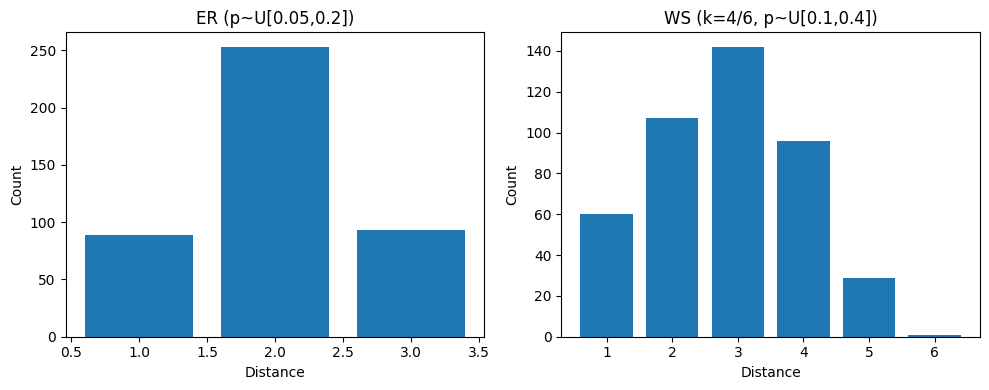

In [21]:
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)
n_nodes = 30
n_graphs = 100

ER = []
while len(ER) < n_graphs:
    p = np.random.uniform(0.05, 0.2)
    G = nx.erdos_renyi_graph(n_nodes, p, seed=None)
    if nx.is_connected(G): ER.append(G)

WS = []
while len(WS) < n_graphs:
    k = np.random.choice([4, 6])
    p = np.random.uniform(0.1, 0.4)
    G = nx.watts_strogatz_graph(n_nodes, k, p, seed=None)
    if nx.is_connected(G): WS.append(G)

labels = np.array([0]*n_graphs + [1]*n_graphs)
all_graphs = ER + WS

idx = np.arange(2*n_graphs)
train_i, test_i = train_test_split(idx, stratify=labels, test_size=0.3, random_state=SEED)
G_train = [all_graphs[i] for i in train_i]
y_train = labels[train_i]
G_test  = [all_graphs[i] for i in test_i]
y_test  = labels[test_i]

print(f"Train: {len(G_train)} graphs, Test: {len(G_test)} graphs")

fig, axes = plt.subplots(1,2, figsize=(10,4))
for G, ax, title in zip([ER[0], WS[0]], axes, ['ER (p~U[0.05,0.2])', 'WS (k=4/6, p~U[0.1,0.4])']):
    dist = dict(nx.all_pairs_shortest_path_length(G))
    lengths = [d for u in dist for v, d in dist[u].items() if u < v]
    ax.hist(lengths, bins=range(1, max(lengths)+2), align='left', rwidth=0.8)
    ax.set(title=title, xlabel='Distance', ylabel='Count')
plt.tight_layout()

## Shortest-Path Kernel

In [22]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
import networkx as nx
from tqdm import tqdm
from itertools import combinations

def compute_kernel(X1, X2=None):
    if X2 is None: X2 = X1
    return np.dot(X1, np.transpose(X2))

def train_precomputed(K_train, y_train, cv_splits=5):
    svc = SVC(kernel='precomputed', probability=True)
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    grid = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy')
    grid.fit(K_train, y_train)
    return grid.best_estimator_, grid.best_params_

def shortest_path_kernel(train_graphs, test_graphs, max_path_length=None, n_samples=None):
    graphs_all = train_graphs + test_graphs
    n = graphs_all[0].number_of_nodes()
    if max_path_length is None:
        maxd = max(
            max(dist.values())
            for G in train_graphs
            for _, dist in nx.all_pairs_shortest_path_length(G)
        )
    else:
        maxd = max_path_length
        
    def feature_matrix(graphs):
        X = np.zeros((len(graphs), maxd))
        for i, G in enumerate(tqdm(graphs, desc='SP build')):
            dist = dict(nx.all_pairs_shortest_path_length(G))
            if n_samples is None:
                for u, v in combinations(range(n), 2):
                    d = dist[u][v]
                    if d <= maxd:
                        X[i, d-1] += 1
            else:
                pairs = [p for p in combinations(range(n),2)]
                idxs = np.random.choice(len(pairs), size=n_samples, replace=False)
                for idx in idxs:
                    u, v = pairs[idx]
                    d = dist[u][v]
                    if d <= maxd:
                        X[i, d-1] += 1
        return X
        
    V_train = feature_matrix(train_graphs)
    V_test  = feature_matrix(test_graphs)

    K_train = V_train.dot(V_train.T)
    K_test  = V_test.dot(V_train.T)
    return K_train, K_test
K_sp_train, K_sp_test = shortest_path_kernel(G_train, G_test)

SP build: 100%|██████████| 60/60 [00:00<00:00, 1663.57it/s]


## Подбор гиперпараметров

Sampling tuning: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


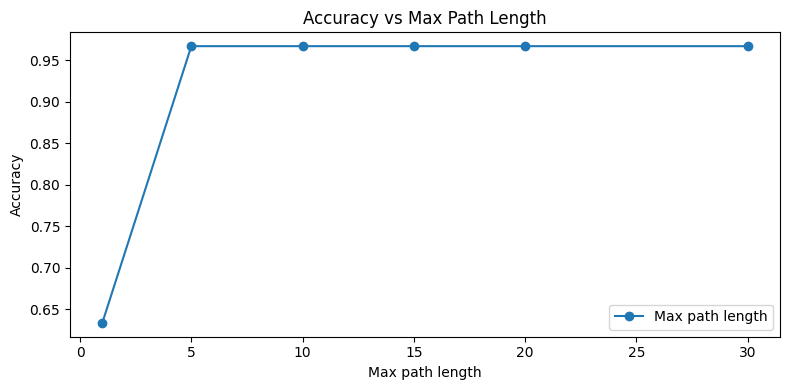

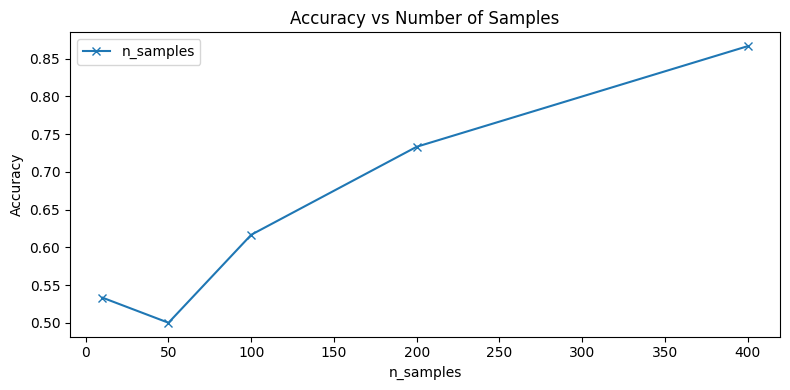

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

MAX_PATH_LENGTHS = [1, 5, 10, 15, 20, 30]
SAMPLES_COUNT    = [None, 10, 50, 100, 200, 400]
path_accuracy    = []
sample_accuracy  = []

for max_path in tqdm(MAX_PATH_LENGTHS, desc='Max path tuning'):
    Ktr, Kte = shortest_path_kernel(G_train, G_test, max_path_length=max_path)
    model = SVC(kernel='precomputed', C=1.0, random_state=SEED)
    model.fit(Ktr, y_train)
    y_pred = model.predict(Kte)
    path_accuracy.append(accuracy_score(y_test, y_pred))

for n_s in tqdm([s for s in SAMPLES_COUNT if s is not None], desc='Sampling tuning'):
    Ktr, Kte = shortest_path_kernel(G_train, G_test, n_samples=n_s)
    model = SVC(kernel='precomputed', C=1.0, random_state=SEED)
    model.fit(Ktr, y_train)
    y_pred = model.predict(Kte)
    sample_accuracy.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(8, 4))
plt.plot(MAX_PATH_LENGTHS, path_accuracy, marker='o', label='Max path length')
plt.xlabel('Max path length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Path Length')
plt.legend()
plt.tight_layout()  
plt.show()

plt.figure(figsize=(8, 4))
x_samples = [s for s in SAMPLES_COUNT if s is not None]
plt.plot(x_samples, sample_accuracy, marker='x', label='n_samples')
plt.xlabel('n_samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Samples')
plt.legend()
plt.tight_layout()
plt.show()

## Реализация Weisfeiler–Lehman Subtree Kernel

In [24]:
from collections import Counter
from hashlib import sha1

def wl_features(graphs, h=3):
    labels = [{v: '0' for v in G.nodes()} for G in graphs]
    feats = [Counter(l.values()) for l in labels]

    for _ in range(h):
        new_labels = []
        for i, G in enumerate(graphs):
            nl = {}
            for v in G.nodes():
                neigh = sorted(labels[i][u] for u in G.neighbors(v))
                tpl = (labels[i][v], *neigh)
                nl[v] = sha1(str(tpl).encode()).hexdigest()
            new_labels.append(nl)
            feats[i].update(nl.values())
        labels = new_labels

    all_labels = sorted({lab for cnt in feats for lab in cnt})
    idx = {lab: j for j, lab in enumerate(all_labels)}
    X = np.zeros((len(graphs), len(all_labels)))
    for i, cnt in enumerate(feats):
        for lab, c in cnt.items():
            X[i, idx[lab]] = c
    return X

X_wl_all   = wl_features(G_train + G_test, h=3)
X_wl_train = X_wl_all[:len(G_train)]
X_wl_test  = X_wl_all[len(G_train):]

K_wl_train = compute_kernel(X_wl_train)
K_wl_test  = compute_kernel(X_wl_test, X_wl_train)

## Обучение SVM и сравнение результатов

SP best C= 0.01
              precision    recall  f1-score   support

           0      0.909     1.000     0.952        30
           1      1.000     0.900     0.947        30

    accuracy                          0.950        60
   macro avg      0.955     0.950     0.950        60
weighted avg      0.955     0.950     0.950        60

WL best C= 0.01
              precision    recall  f1-score   support

           0      0.967     0.967     0.967        30
           1      0.967     0.967     0.967        30

    accuracy                          0.967        60
   macro avg      0.967     0.967     0.967        60
weighted avg      0.967     0.967     0.967        60



Text(0.5, 1.0, 'ROC Curves')

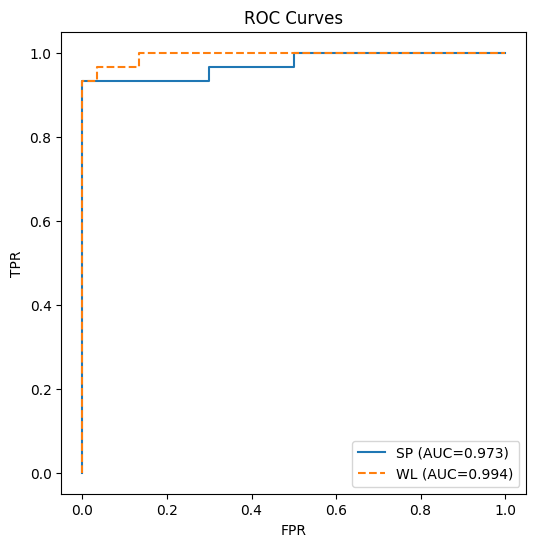

In [25]:
# SP
clf_sp, params_sp = train_precomputed(K_sp_train, y_train)
y_pred_sp = clf_sp.predict(K_sp_test)
y_score_sp = clf_sp.decision_function(K_sp_test)
print("SP best C=", params_sp['C'])
print(classification_report(y_test, y_pred_sp, digits=3))

# WL
clf_wl, params_wl = train_precomputed(K_wl_train, y_train)
print("WL best C=", params_wl['C'])

y_pred_wl = clf_wl.predict(K_wl_test)
y_score_wl = clf_wl.decision_function(K_wl_test)
print(classification_report(y_test, y_pred_wl, digits=3))

# ROC plot
import matplotlib.pyplot as plt
fpr_sp, tpr_sp, _ = roc_curve(y_test, y_score_sp)
fpr_wl, tpr_wl, _ = roc_curve(y_test, y_score_wl)
plt.figure(figsize=(6,6))
plt.plot(fpr_sp, tpr_sp, label=f'SP (AUC={auc(fpr_sp,tpr_sp):.3f})')
plt.plot(fpr_wl, tpr_wl, '--', label=f'WL (AUC={auc(fpr_wl,tpr_wl):.3f})')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('ROC Curves')

Оба ядра (Shortest-Path и Weisfeiler–Lehman) дают высокие метрики на этой задаче бинарной классификации.

Однако Weisfeiler–Lehman Kernel стабильно превосходит Shortest-Path Kernel по точности и сбалансированности (f1≈0.967 против 0.950)